# Robust multigrid for IGA based on subspace correction


This notebook implements some basic 1D, 2D and 3D examples which demonstrate the
robust multigrid method for Isogeometric Analysis described in the paper

[C. Hofreither and S. Takacs. Robust Multigrid for Isogeometric Analysis Based on Stable Splittings of Spline Spaces.](http://dx.doi.org/10.1137/16m1085425)

Only the two-grid method on the reference domain is implemented.
It uses the function `twogrid`, a generic two-grid method, as well
as the abstract `SubspaceOperator`, which is used as a
subspace correction smoother as described in the paper.

A crucial component of the method is the computation of a basis for the
space $\widetilde S$ of splines with vanishing odd derivatives at the
boundary (denoted by $S_0$ in the paper). This is done using the
function `Stilde_basis` from `pyiga.stilde`.

There are also some simple tests for the Dirichlet BC case. The method
we use here is not the one described in the paper which involves
adaptation of the space $S_0$, but a simple algebraic approach based
on truncating the subspace prolongation matrix: the first and last row,
corresponding to the Dirichlet dofs, are simply dropped. While we don't
currently have a proof for this approach, it seems to work very well in
practice and is easy to implement.

This notebook depends on the [`pyiga` toolbox](https://github.com/c-f-h/pyiga).

In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse import kron as spkron

from pyiga import bspline, assemble
from pyiga.operators import KroneckerOperator, make_solver, SubspaceOperator
from pyiga.solvers import *
from pyiga.stilde import Stilde_basis

In [2]:
%pylab inline
plt.style.use('bmh')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def random_rhs(A):
    return A.dot(rand(A.shape[1]))

# 1D Multigrid

In [32]:
p = 7
nspans_c = 100

kv_c = bspline.make_knots(p, 0.0, 1.0, nspans_c)
kv = kv_c.refine()
h = 1.0 / kv.numspans

M = assemble.mass(kv)
K = assemble.stiffness(kv)
A = 1.0*M + K

P = bspline.prolongation(kv_c, kv)

print('Coarse dofs: %d\nFine dofs: %d' % (P.shape[1], A.shape[0]))

Coarse dofs: 107
Fine dofs: 207


In [33]:
# construct prolongator for S-tilde and its orthogonal complement
(P_tilde, P_compl) = Stilde_basis(kv)

# basis for M-orthogonal complement of S-tilde
P_tilde_orth = solve(M.A, P_compl)  # M^-1 * P_compl

A_tilde_orth = P_tilde_orth.T.dot(A.A).dot(P_tilde_orth)

M_tilde = P_tilde.T.dot(M.A).dot(P_tilde)

In [36]:
sigma = h**-2 / 0.09

smoother1 = OperatorSmoother(SubspaceOperator(
    [P_tilde,                             P_tilde_orth],
    [make_solver((1 + sigma) * M_tilde),  make_solver(A_tilde_orth)]
))
smoother2 = GaussSeidelSmoother()
smoother3 = SequentialSmoother((smoother1, smoother2))

twogrid(A, random_rhs(A), P, smoother3);

7 iterations


In [37]:
# Dirichlet test
sigma = h**-2 / 0.09

K_dir = K[1:-1,1:-1]
smoother = OperatorSmoother(SubspaceOperator(
    [P_tilde[1:-1],                       P_tilde_orth[1:-1]],
    [make_solver((1 + sigma) * M_tilde),  make_solver(A_tilde_orth)]
))
twogrid(K_dir, random_rhs(K_dir), P[1:-1], smoother);

31 iterations


In [8]:
Linv = P_tilde_orth .dot (inv(A_tilde_orth)) .dot (P_tilde_orth.T) + \
       P_tilde .dot(inv((1 + sigma) * M_tilde)) .dot (P_tilde.T)

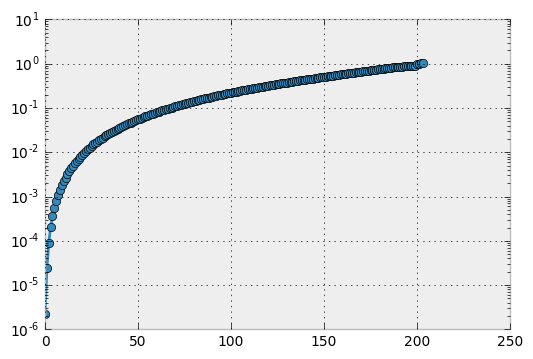

In [9]:
semilogy(scipy.linalg.eigh(A.A, inv(Linv), eigvals_only=True), 'o-');

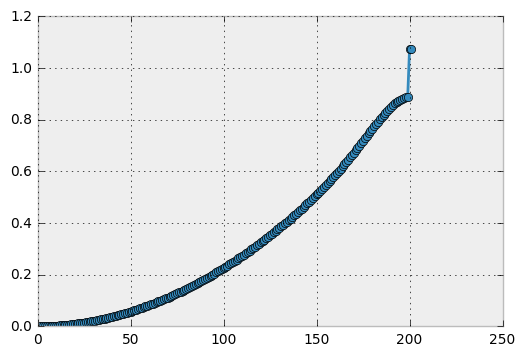

In [10]:
plot(scipy.linalg.eigh(A.A[1:-1,1:-1], inv(Linv[1:-1,1:-1]), eigvals_only=True), 'o-');

# 2D Multigrid

In [11]:
p = 4
nspans_c = 25

kv_c = bspline.make_knots(p, 0.0, 1.0, nspans_c)
kv = kv_c.refine()
h = 1.0 / kv.numspans

M = assemble.mass(kv)
K = assemble.stiffness(kv)

M2 = spkron(M, M).tocsr()
K2 = spkron(K, M) + spkron(M, K)

A2 = 1.0*M2 + K2

P = bspline.prolongation(kv_c, kv)
P2 = spkron(P, P)

print('Coarse dofs: %d\nFine dofs: %d' % (P2.shape[1], A2.shape[0]))

Coarse dofs: 841
Fine dofs: 2916


In [12]:
# construct prolongator for S-tilde and its orthogonal complement
(P_tilde, P_compl) = Stilde_basis(kv)

# basis for 2D S-tilde
P2_tilde = spkron(P_tilde, P_tilde).tocsr()

M2_tilde = (P2_tilde.T).dot(M2).dot(P2_tilde)

# compute basis for M-orthogonal complement of S-tilde
P_tilde_orth = solve(M.A, P_compl)  # M^-1 * P_compl

subsp = (
    P2_tilde,
    kron(P_tilde, P_tilde_orth),
    kron(P_tilde_orth, P_tilde),
    kron(P_tilde_orth, P_tilde_orth)
)

sigma = 1 / 0.16 * h**-2

B = ((1 + sigma) * M + K).A
B_tilde_orth = P_tilde_orth.T.dot(B).dot(P_tilde_orth)
M_sm_tilde = P_tilde.T.dot(M.A).dot(P_tilde)

B_subsp = [
    (1 + 2*sigma) * M2_tilde,
    spkron(M_sm_tilde, B_tilde_orth),
    spkron(B_tilde_orth, M_sm_tilde),
    subsp[3].T.dot(A2.A).dot(subsp[3])
]

Binv_subsp = [make_solver(B) for B in B_subsp]

smoother1 = OperatorSmoother(SubspaceOperator(subsp, Binv_subsp))
smoother2 = GaussSeidelSmoother()
smoother3 = SequentialSmoother((smoother1, smoother2))

twogrid(A2, random_rhs(A2), P2, smoother3);

9 iterations


In [13]:
# Dirichlet test

# modify subspace prolongators to omit Dirichlet dofs
subsp = (
    spkron(P_tilde[1:-1], P_tilde[1:-1]).tocsr(),
    kron(P_tilde[1:-1], P_tilde_orth[1:-1]),
    kron(P_tilde_orth[1:-1], P_tilde[1:-1]),
    kron(P_tilde_orth[1:-1], P_tilde_orth[1:-1])
)

# keep smoothers the same as before

# compute Dirichlet stiffness matrix
M2_D = spkron(M[1:-1,1:-1], M[1:-1,1:-1]).tocsr()
K2_D = spkron(K[1:-1,1:-1], M[1:-1,1:-1]) + spkron(M[1:-1,1:-1], K[1:-1,1:-1])
A2_D = K2_D #+ M2_D

smoother = OperatorSmoother(SubspaceOperator(subsp, Binv_subsp))
twogrid(A2_D, random_rhs(A2_D), spkron(P[1:-1], P[1:-1]), smoother);

35 iterations


# 3D Multigrid

In [14]:
def spkron3(A, B, C):
    return spkron(spkron(A, B, format='csr'), C, format='csr')

In [15]:
p = 5
nspans_c = 10

kv_c = bspline.make_knots(p, 0.0, 1.0, nspans_c)
kv = kv_c.refine()
h = 1.0 / kv.numspans

M = assemble.mass(kv)
K = assemble.stiffness(kv)

M3 = spkron3(M, M, M)
K3 = spkron3(K, M, M) + spkron3(M, K, M) + spkron3(M, M, K)

A3 = 1.0*M3 + K3

P = bspline.prolongation(kv_c, kv)
P3 = spkron3(P, P, P)

print('Coarse dofs: %d\nFine dofs: %d' % (P3.shape[1], A3.shape[0]))

Coarse dofs: 3375
Fine dofs: 15625


In [16]:
# construct prolongator for S-tilde and its orthogonal complement
(P_tilde, P_compl) = Stilde_basis(kv)

# compute basis for M-orthogonal complement of S-tilde
P_tilde_orth = solve(M.A, P_compl)  # M^-1 * P_compl

In [22]:
sigma = 1 / 0.19 * h**-2

# 1D smoother components
B = ((1 + 2*sigma) * M + K).A
B_tilde_orth = P_tilde_orth.T.dot(B).dot(P_tilde_orth)
M_tilde = scipy.sparse.csr_matrix(P_tilde.T.dot(M.A).dot(P_tilde))

subsp, Binv_subsp = 2**3 * [None], 2**3 * [None]

for i in range(2**3):
    bits = [bool(i & (1<<k)) for k in range(3)]
    num_compl = sum(bits)  # number of components which are the orthogonal complement

    prolongators = [P_tilde_orth if bits[j] else P_tilde for j in range(3)]
    P_i = subsp[i] = spkron3(*prolongators)

    if num_compl == 0:
        # inner part (S-tilde): use mass smoother
        M_tilde_inv = make_solver(M_tilde, symmetric=True)  # 1D solver for M-tilde
        Binv_subsp[i] = 1/(1 + 3*sigma) * KroneckerOperator(*(3*[M_tilde_inv]))
    elif num_compl == 1:
        # faces: use Kronecker product smoother
        smoothers = [B_tilde_orth if bits[j] else M_tilde for j in range(3)]
        Binv_subsp[i] = KroneckerOperator(*[make_solver(X, symmetric=True) for X in smoothers])
    else:
        # edges and corners (small): use direct solver
        fullness = P_i.nnz / prod(P_i.shape)
        if fullness > 0.4:
            P_i = P_i.A  # use dense matrix
            B = P_i.T.dot(A3.dot(P_i))
        else:
            B = (P_i.T.dot(A3.dot(P_i))).A
        Binv_subsp[i] = make_solver(B, symmetric=True)

smoother1 = OperatorSmoother(SubspaceOperator(subsp, Binv_subsp))
smoother2 = GaussSeidelSmoother()
smoother3 = SequentialSmoother((smoother1, smoother2))

In [24]:
twogrid(A3, random_rhs(A3), P3, smoother1);

33 iterations


In [19]:
# Dirichlet test

# compute new subspace prolongators which omit Dirichlet dofs
for i in range(2**3):
    bits = [bool(i & (1<<k)) for k in range(3)]
    prolongators = [P_tilde_orth[1:-1] if bits[j] else P_tilde[1:-1] for j in range(3)]
    subsp[i] = spkron3(*prolongators)

P3_D = spkron3(P[1:-1], P[1:-1], P[1:-1])

M_D = M[1:-1, 1:-1]
K_D = K[1:-1, 1:-1]

K3_D = spkron3(K_D, M_D, M_D) + spkron3(M_D, K_D, M_D) + spkron3(M_D, M_D, K_D)

smoother = OperatorSmoother(SubspaceOperator(subsp, Binv_subsp))
twogrid(K3_D, random_rhs(K3_D), P3_D, smoother);

30 iterations
